# Introduction to NLP

# Using a CNN for a text classification problem

In a text classification problem we search for some paterns or clues in the text that provide some information to help us to identify the text class. A CNN model is usually a great tool for image classification because it can find patterns in the pixels. CNNs are generally used in computer vision, however they’ve recently been applied to various NLP tasks and the results were promising.

Let’s briefly see what happens when we use CNN on text data through a diagram.The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words).Patterns could be expressions (word ngrams?) like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position.


Link to problem descripotion in Kaggle:

Link to blog post or aditional readings:


### Importing the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
import re

from collections import Counter
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edumu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


### Loading the datasets

In [2]:
# Load the train dataset
train = pd.read_csv('train.csv')
# Load the test dataset
test = pd.read_csv('test.csv')
#submission = pd.read_csv('sample_submission.csv')

In [3]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Preprocess the text dataset

We are applying some basic cleaning techniques. 

This notebook does not cover how to implement the best preprocessor to clean our tweets. So we are going to feed our model with the tweet as is or only removing no alphanumeric characters. For a better results, we should inspect the tweets and apply some cleaning removing useless words, mispelling words, maybe the URIs,... 

In [4]:
# turn a doc into clean tokens
def clean_doc(doc):
    ''' Clean the text in the doc return its token to be considered
        - Remove nonalphanumeric strings
        - Remove punctuation from a word
        - Lower the words
        - Remove stop words
        - Remove one-character tokens 
    Input:
        doc: string, the input text to clean
    Output:
        tokens: list, list of tokens after cleaning'''
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc and add to vocab
def add_tokens_to_vocab(tokens, vocab):
    ''' Load a text file, extract tokens and include them on the vocab'''
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

# fit a tokenizer
def create_tokenizer(lines):
    ''' Create a tokenizer for the text lines'''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    ''' Tokenize or numericalize the docs then padd the sequences'''
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded


In [5]:
# Extract the text data on the datasets
train_sentences = train['text']
test_sentences = test['text']
# Create the target variable
y_train = train['target'].values

In [96]:
train_sentences= train_sentences.apply(lambda x: clean_doc(x))
test_sentences= test_sentences.apply(lambda x: clean_doc(x))

In [97]:
test_sentences

0                        [happened, terrible, car, crash]
1       [heard, earthquake, different, cities, stay, s...
2       [forest, fire, spot, pond, geese, fleeing, acr...
3              [apocalypse, lighting, spokane, wildfires]
4               [typhoon, soudelor, kills, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, safety, fas...
3259    [storm, ri, worse, last, hurricane, hardest, h...
3260    [green, line, derailment, chicago, httptcoutbx...
3261      [meg, issues, hazardous, weather, outlook, hwo]
3262    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 3263, dtype: object

In [98]:
# define vocab
vocab = Counter()
for i in range(len(train_sentences)):
    vocab.update(train_sentences[i])

for i in range(len(test_sentences)):
    vocab.update(test_sentences[i])

vocab_size=len(vocab)+1

In [99]:
print('Length Vocabulary: ',vocab_size)

Length Vocabulary:  21307


In [68]:
print(vocab.most_common(50))

[('like', 490), ('amp', 434), ('im', 419), ('fire', 357), ('get', 335), ('new', 326), ('via', 324), ('news', 282), ('people', 278), ('one', 277), ('dont', 260), ('us', 236), ('emergency', 225), ('video', 225), ('disaster', 212), ('would', 206), ('police', 196), ('still', 179), ('suicide', 173), ('body', 168), ('crash', 167), ('burning', 167), ('first', 166), ('storm', 166), ('rt', 163), ('attack', 162), ('time', 161), ('got', 160), ('back', 158), ('know', 155), ('california', 154), ('fires', 152), ('buildings', 150), ('see', 149), ('going', 149), ('man', 145), ('love', 144), ('day', 144), ('two', 144), ('world', 143), ('cant', 142), ('bomb', 142), ('nuclear', 141), ('full', 140), ('go', 138), ('hiroshima', 136), ('dead', 135), ('youtube', 135), ('watch', 135), ('today', 132)]


In [121]:
oov_tok = "<OOV>"
BATCH_SIZE = 128
EPOCHS=50


In [100]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, char_level=False,  lower=False)
tokenizer.fit_on_texts(list(train_sentences)+list(test_sentences))
print(len(tokenizer.word_index))
#vocab_size = len(tokenizer.word_index) + 1

21307


In [101]:
max_length = max([len(train_sentences[i]) for i in range(len(train_sentences))])

In [102]:
max_length

23

In [103]:
# integer encode
train_seq = tokenizer.texts_to_sequences(train_sentences)
test_seq = tokenizer.texts_to_sequences(test_sentences)
# pad sequences
train_pad = pad_sequences(train_seq, maxlen=max_length, padding='post')
test_pad = pad_sequences(test_seq, maxlen=max_length, padding='post')

In [130]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(32, 8, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001), metrics=['accuracy'])
    # summarize defined model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [131]:
model = define_model(vocab_size, max_length)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 23, 100)           2130700   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16, 32)            25632     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
___________________________

In [132]:
print(train_pad.shape, test_pad.shape,y_train.shape)
print(type(train_pad),type(test_pad),type(y_train))

(7613, 23) (3263, 23) (7613,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [107]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train_pad,y_train,test_size=0.20, random_state=0)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6090, 23)
Shape of Validation  (1523, 23)


In [133]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_loss", mode="min", verbose=True, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min', verbose=1, min_lr=0.000001)

In [134]:
history=model.fit(X_train,Y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_val,Y_val),callbacks=[checkpoints, reduce_lr, early_stop],
                  verbose=1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 4s 673us/step - loss: 0.6744 - acc: 0.5836 - val_loss: 0.6466 - val_acc: 0.7006

Epoch 00001: val_loss improved from inf to 0.64664, saving model to weights.hdf5
Epoch 2/50
6090/6090 [==============================] - 3s 443us/step - loss: 0.5147 - acc: 0.7897 - val_loss: 0.4528 - val_acc: 0.7866

Epoch 00002: val_loss improved from 0.64664 to 0.45284, saving model to weights.hdf5
Epoch 3/50
6090/6090 [==============================] - 3s 452us/step - loss: 0.2703 - acc: 0.9076 - val_loss: 0.4922 - val_acc: 0.7905

Epoch 00003: val_loss did not improve from 0.45284
Epoch 4/50
6090/6090 [==============================] - 3s 453us/step - loss: 0.1603 - acc: 0.9511 - val_loss: 0.5545 - val_acc: 0.7840

Epoch 00004: val_loss did not improve from 0.45284

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
6090/6090 [==============================] 

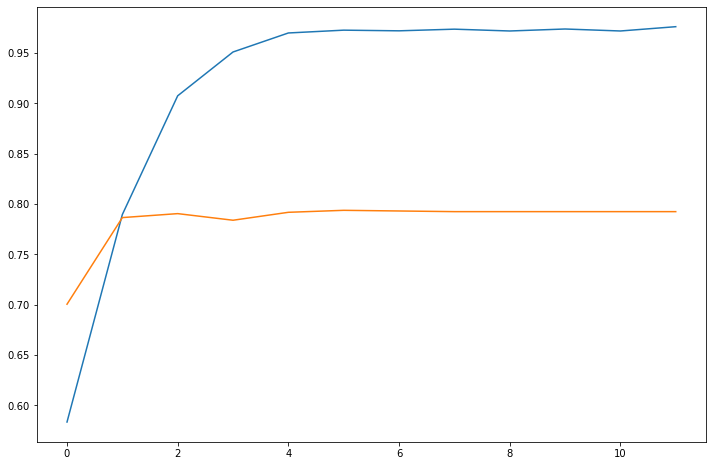

In [138]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()

In [139]:
#Load the weights of the best model
model.load_weights('weights.hdf5')

In [140]:
y_pre=model.predict(test_pad)
submission.iloc[:, 1] = (y_pre > 0.5).astype(int)
submission.to_csv('submission.csv',index=False)